In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math
import cv2
import os
from os.path import isfile, join
from numba import jit, cuda,njit

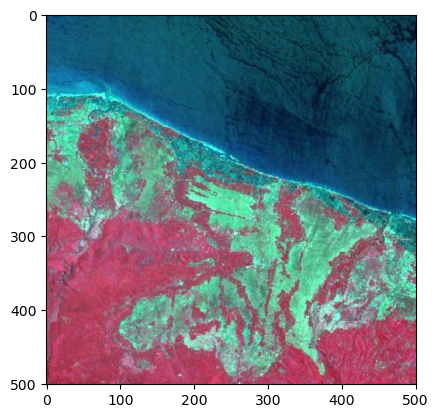

In [2]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
def cut_image(img,x,y,t1,t2):
    return img[x:t1+x,y:t2+y,:]
img=plt.imread("FalseColorImages.jpg")
#img=cut_image(img,0,0,500,500)
plt.imshow(img)
gray_img=rgb2gray(img)

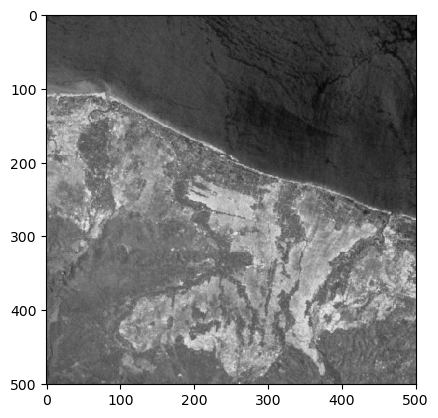

In [3]:
plt.imshow(gray_img,cmap="gray")

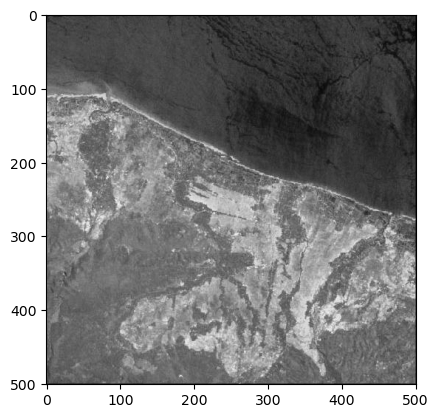

In [4]:
def gauss(x,y,sigma=0.01):
    return (((1)/(2*np.pi*sigma**2))*(np.exp(-(x**2+y**2)/(2*sigma**2))))


def gauss_filter(shape=(3,3)):
    a=np.ones(shape)

    for x in range(a.shape[0]):
        for y in range(a.shape[1]):
   
            a[x][y]=gauss(x,y,0.1)
    return a


def filter_img(img):
    n=img.shape[0]
    m=img.shape[1]
    a=img.copy()
    filter=gauss_filter()

    for x in range(1,n-1):
        for y in range(1,m-1):
            
            a[x][y]=np.round(np.mean(np.multiply(img[x-1:x+2,y-1:y+2],filter)))
       
    return a
gray_filterd_img=filter_img(gray_img)
plt.imshow(gray_filterd_img,cmap="gray")

<h3>Utility Functions</h3>

In [ ]:
#function to convole the image with a filter
def convolve(img,filter):
    x_filter=filter.shape[0]
    y_filter=filter.shape[0]
    cp=img.copy()
    n=img.shape[0]
    m=img.shape[1]
    for x in range(x_filter%2,n-(x_filter//2)):
        for y in range(y_filter%2,m-(y_filter//2)):
        
           
            tmp=np.sum((img[x-x_filter%2:(x+x_filter//2)+1,y-y_filter%2:y+(y_filter//2)+1])*filter)
            if(tmp>255):

                cp[x][y]=255
            else:
                cp[x][y]=tmp


    return cp


#calculae the amplitude
def amplitude(gx,gy):
    return np.sqrt(gx**2+gy**2) 
#calculae the angle
def angle(gx,gy):
    return np.arctan2(-gx,gy)

<h3>First Order Filters:</h3>
<h4>Robert Filter</h4>
<p>I have chosed the robert filter which uses a mask :</p>
<p>[[1,0],[0,-1 ]] filter for gx and [[0,1],[-1,0]] for gy.</p>

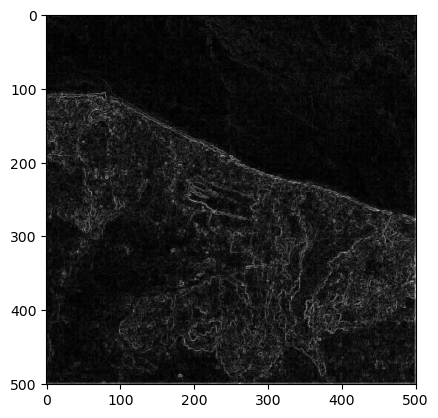

In [5]:



gx_filter=np.array([[1,0],[0,-1]])
gy_filter=np.array([[0,1],[-1,0]])


gx=convolve(gray_filterd_img,gx_filter)
gy=convolve(gray_filterd_img,gy_filter)


G=amplitude(gx,gy)
O=angle(gx,gy)

plt.imshow(G,cmap="gray")

<h3>Second Order Filters:</h3>
<h4>Laplace Filter</h4>
<ol>
<li>We first convole the image with a filter of [[-1,-1,-1],[-1,8,-1],[-1,-1,-1]]</li>
<li>We select a threshold,by trial threshold between 180 and 200 were good.  </li>
</ol>

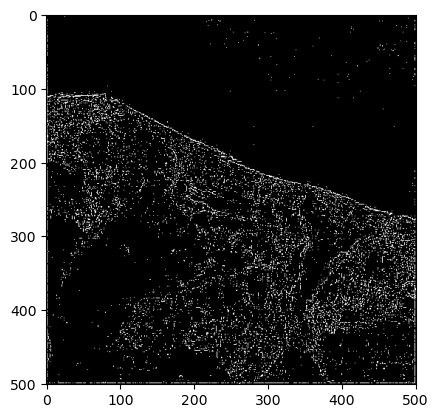

In [32]:
laplacien_filter=np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])
g=convolve(gray_filterd_img,laplacien_filter)
def seuillage(img,seuil=190):
    cp=img.copy()
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if(img[x][y]>=seuil):
                cp[x][y]=255
            else:
                cp[x][y]=0
    return cp

s=seuillage(g)
plt.imshow(s,cmap="gray")    
    

<h3>Step2: Segmentation</h3>
<h4>Histogram for each channel</h4>

In [51]:
def rgb_components(img):
    img=img.copy()
    return img[:,:,0],img[:,:,1],img[:,:,2]

r,g,b=rgb_components(img)





<p>For segmentaion i have both used the manual by observing the pics in the histogram method and the automatic method using the ostu method, and it turns out the the manual metohd works for me. </p>

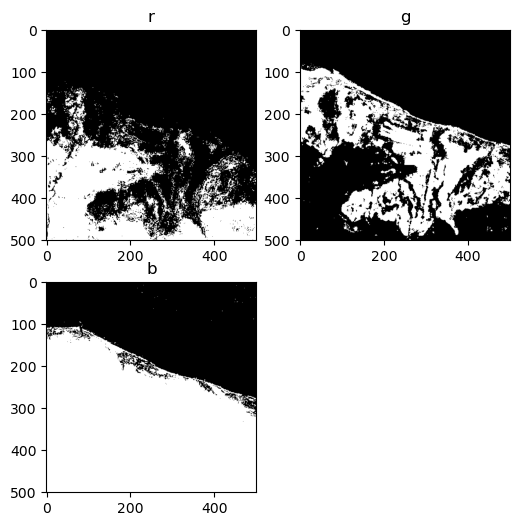

In [42]:
#segmenation function which sets the pixel to 1 if it passes a given threshold
def segmentation(img,thresh_up):
    cp=img.copy()
    for x in range(cp.shape[0]):
        for y in range(cp.shape[1]):
            if(cp[x][y]>=thresh_up):
                cp[x][y]=255
            else:
                cp[x][y]=0
    return cp

segmented_image1=segmentation(r,145)
segmented_image2=segmentation(g,127)
segmented_image3=segmentation(r,36)
plt.figure(figsize=(6,6))
plt.subplot(2,2,1)
plt.title("r")
plt.imshow(segmented_image1,cmap="gray") 
plt.subplot(2,2,2)
plt.title("g")
plt.imshow(segmented_image2,cmap="gray") 
plt.subplot(2,2,3)
plt.title("b")
plt.imshow(segmented_image3,cmap="gray") 

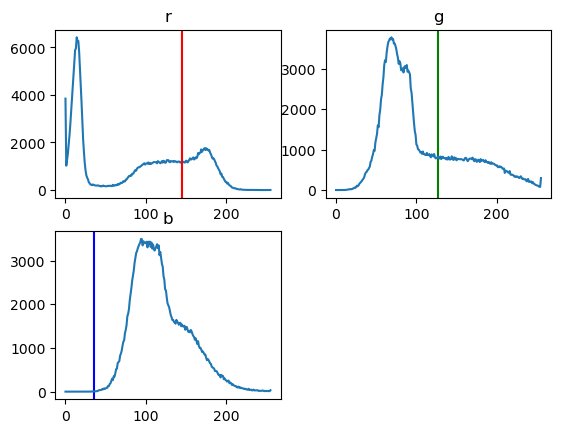

In [54]:
rh, bin_edges = np.histogram(r, bins=256, range=(0, 256))
plt.subplot(2,2,1)
plt.title("r")
plt.plot(bin_edges[0:-1], rh)
plt.axvline(x = 145, color = 'r', label = 'axvline - full height')
gh, bin_edges = np.histogram(g, bins=256, range=(0, 256))
plt.subplot(2,2,2)
plt.title("g")
plt.axvline(x = 127, color = 'g', label = 'axvline - full height')
plt.plot(bin_edges[0:-1], gh)

bh, bin_edges = np.histogram(b, bins=256, range=(0, 256))
plt.subplot(2,2,3)
plt.axvline(x = 36, color = 'b', label = 'axvline - full height')
plt.title("b")
plt.plot(bin_edges[0:-1], bh)


<h3>Otsu’s method</h3>

In [34]:


def wc1(h,thresh):
    return np.sum([h[i] for i in range(0,thresh)])
def wp1(h,thresh):
    return np.sum([h[i] for i in range(0,thresh)])/250000

def mean1(h,thresh):
    w=wc1(h,thresh)
    
    if(w==0):
        return 0
    return (1/w)*(np.sum([h[i]*i for i in range(0,thresh)]))


def variance1(h,thresh):
    w=wc1(h,thresh)
    if(w==0):
        return 0
    return (1/w)*(np.sum([np.square(i-mean1(h,thresh))*h[i] for i in range(0,thresh)]))



def wc2(h,thresh):
    return np.sum([h[i] for i in range(thresh,256)])
def wp2(h,thresh):
    return np.sum([h[i] for i in range(thresh,256)])/250000


def mean2(h,thresh):
    w=wc2(h,thresh)
    if(w==0):
        return 0

  
    return (1/w)*(np.sum([h[i]*i for i in range(thresh,256)]))


def variance2(h,thresh):
    w=wc2(h,thresh)
    if(w==0):
        return 0
   
    return (1/w)*np.sum([np.square(i-mean2(h,thresh))*h[i] for i in range(thresh,256)])




arr=[]

for i in range(1,256):
    temp=wp1(rh,i)*variance1(rh,i)+wp2(rh,i)*variance2(rh,i)
    
    arr.append(temp)
arr=np.array(arr)
print(np.argmin(arr))   

81


<h3>Step3: Clustering using the k-mediods algorithm</h3>
<h5>Algorithm description</h5>
<ol>
<li>Initialize: select k random points out of the n data points as the medoids.</li>
<li>Associate each data point to the closest medoid by using any common distance metric methods.</li>
<li>
While the cost decreases: For each medoid m, for each data o point which is not a medoid: 
Swap m and o, associate each data point to the closest medoid, and recompute the cost. 
If the total cost is more than that in the previous step, undo the swap.</li>


</ol>

Source: <a href="https://www.geeksforgeeks.org/ml-k-medoids-clustering-with-example" >https://www.geeksforgeeks.org/ml-k-medoids-clustering-with-example/</a>


<p>Because trying all the possibilites of centroids being in the image then getting the best one's the gives the best result will require a lot of computation and space. i have choosed random centroids in the begining, and the registering the best possible result by running the alogrithm several times.     </p>
<p>For that the i have found that best position of centroids in case of 3 clusters is: [(480, 466), (114, 454), (394, 455)] for c1,c2,c3 respectively.</p>

iter n 0
iter n 1
[(480, 466), (114, 454), (394, 455)]


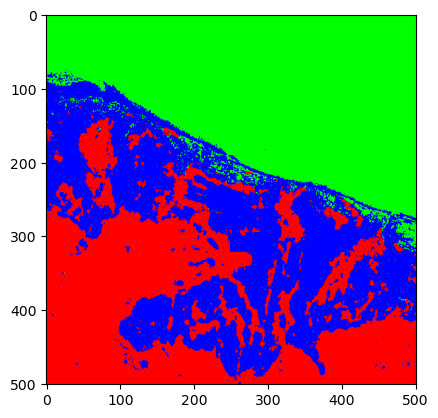

In [69]:
#function to get the random numbers
def get_random_point(n,m):
    x=np.random.randint(0,n)
    y=np.random.randint(0,m)
    return x,y

#function to get the random centroids
def get_clusters_positions(k):
    n=img.shape[0]
    m=img.shape[1]
    arr=[]
    for i in range(k):
        x,y=get_random_point(n,m)
        arr.append((x,y))
    return arr    
#function to get the  centroids values
def get_clusters(positions,img):
    arr=[]
    for x,y in positions:
        arr.append(img[x][y])
    return arr  
#function to check if a given point is a cluster (to not calculate distance with it)
def is_cluster(point,clusters):
    
    for cluster in clusters:
        if(point[0]==cluster[0] and point[1]==cluster[1]):
            return True
    return False        
@njit
def calculate_distance(x1,x2):
    #return np.sum(np.absolute(x1-x2))
    return np.sqrt(np.sum((x1-x2)**2))

#function to get the closest point to the clusters 
def get_closeset_to_cluster(point,clusters):
   
    arr=[calculate_distance(point,cluster) for cluster in clusters]    
    min_index=np.argmin(arr)
    min_value=arr[min_index]
    
    return min_index,min_value

def get_distances_dict(k):
    dic={}
    for i in range(k):
        dic[i]=[]
    return dic    

#main
def k_mediods(k,img):
    n=img.shape[0]
    m=img.shape[1]
    cp=img.copy()
 
    clusters_positons=get_clusters_positions(k)
    clusters=get_clusters(clusters_positons,img)
   
    cost=0
    prev_cost=0
    distance_dict=get_distances_dict(k)
    for x in range(n):
            for y in range(m):
                if(not is_cluster((x,y),clusters_positons)):
                    min_index,min_value=get_closeset_to_cluster(img[x][y],clusters)
                    distance_dict[min_index].append(np.array([x,y,min_value]))
                    
    distance_array=list(map(lambda x:np.array(x),list(distance_dict.values())))
  
    #prev_cost=np.sum(distance_array[:,2])          
    prev_cost=sum([np.sum(a[:,2]) for a in distance_array])

    
    prev_arr=distance_array 

    i=0
    while True:
        
        clusters_positons=get_clusters_positions(k)
        clusters=get_clusters(clusters_positons,img)
        distance_dict=get_distances_dict(k)

        for x in range(n):
            for y in range(m):
                if(not is_cluster((x,y),clusters_positons)):
                   min_index,min_value=get_closeset_to_cluster(img[x][y],clusters)
                   distance_dict[min_index].append(np.array([x,y,min_value]))  
                   
                       
        distance_array=list(map(lambda x:np.array(x),list(distance_dict.values())))
        cost=sum([np.sum(a[:,2]) for a in distance_array])
        
        if(cost-prev_cost>0 or i==30):       
            
            break
       
        print(f"iter n {i}")
        i+=1
        
        prev_arr=distance_array 
        prev_cost=cost
       

    return (prev_arr,clusters_positons)

       
        



for i in range(1):
    res=k_mediods(3,img)

    arr1,arr2,arr3=res[0]
    clusters_positons=res[1]
    print(clusters_positons)
    cp=img.copy()
   
    for item in arr1:
        
        cp[int(item[0])][int(item[1])][0]=255
        cp[int(item[0])][int(item[1])][1]=0
        cp[int(item[0])][int(item[1])][2]=0
    for item in arr2:
        cp[int(item[0])][int(item[1])][0]=0
        cp[int(item[0])][int(item[1])][1]=255
        cp[int(item[0])][int(item[1])][2]=0
        
    for item in arr3:
        cp[int(item[0])][int(item[1])][0]=0 
        cp[int(item[0])][int(item[1])][1]=0
        cp[int(item[0])][int(item[1])][2]=255
   # plt.figure(figsize=(12,12))
   # plt.subplot(2,3,i+1)
    plt.imshow(cp)    






<h4>Links Used for the segmentation and clustering steps</h4>

https://en.wikipedia.org/wiki/Otsu%27s_method


https://vincmazet.github.io/bip/segmentation/histogram.html



https://www.geeksforgeeks.org/ml-k-medoids-clustering-with-example/